In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import logging
from typing import Callable, List
from collections import Counter

import numpy as np
from skimage.color import gray2rgb, rgb2gray, label2rgb
from skimage.util import montage
from skimage.data import astronaut
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from src.utils.logger import get_logger
from src.surrogate.lime import LimeImageSummarizer

import matplotlib.pyplot as plt

In [3]:
_ = get_logger(logging.ERROR)

## Download Dataset

In [4]:
dataset = fetch_olivetti_faces()

In [5]:
dataset.data.shape

(400, 4096)

In [6]:
dataset.images.shape

(400, 64, 64)

In [7]:
dataset.target.shape

(400,)

In [8]:
all(dataset.data[0] == dataset.images[0].flatten())

True

## About Olivetti faces Dataset
- Consists of 400 face images of 40 subjects (10 images per each subject)
- Each image's shape is 64x64 (gray-scale)

In [9]:
images = np.stack([gray2rgb(img) for img in dataset.images], axis=0)

(-0.5, 639.5, 2559.5, -0.5)

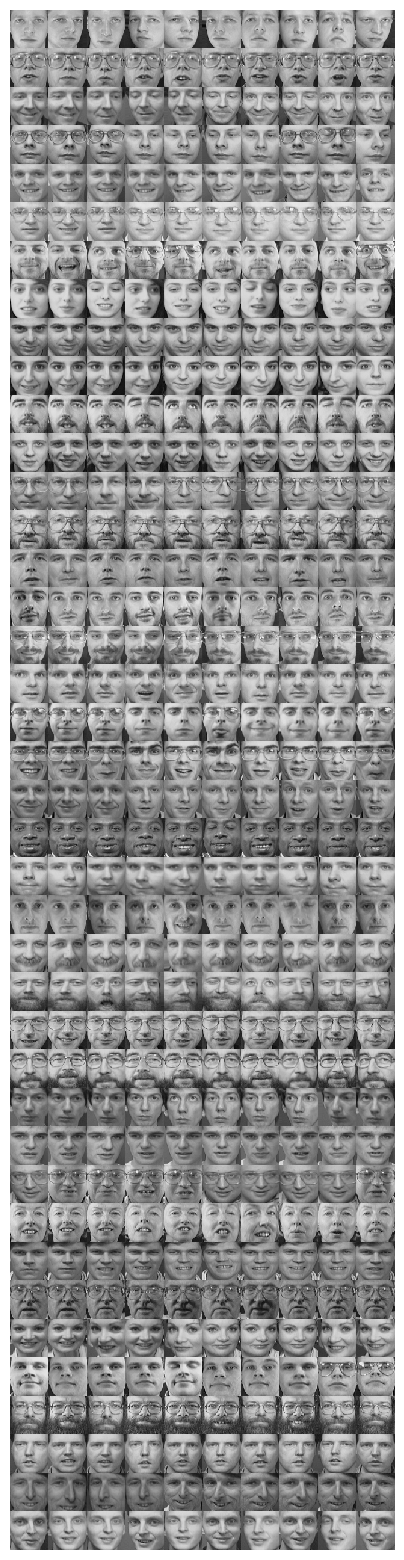

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20))
ax.imshow(montage(images[..., 0], grid_shape=(40, 10)), cmap="gray", interpolation="none")
ax.axis("off")

## Preprocess Dataset

In [11]:
X_raw = dataset.images
y_raw = dataset.target

X_rgb = gray2rgb(X_raw)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_rgb,
    y_raw,
    train_size=0.70,
    random_state=1234,
    # stratify=y_raw,
)

In [13]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (280, 64, 64, 3)
y_train: (280,)
X_test: (120, 64, 64, 3)
y_test: (120,)


In [14]:
y_train_counts = Counter(y_train)
y_test_counts = Counter(y_test)

for i in range(40):
    n_train = y_train_counts.get(i, 0)
    n_test = y_test_counts.get(i, 0)
    print(f"Label: {i:>2} => train: {n_train:>2}, test: {n_test:>2}")

Label:  0 => train:  9, test:  1
Label:  1 => train:  8, test:  2
Label:  2 => train:  7, test:  3
Label:  3 => train:  7, test:  3
Label:  4 => train:  7, test:  3
Label:  5 => train:  6, test:  4
Label:  6 => train:  7, test:  3
Label:  7 => train:  5, test:  5
Label:  8 => train: 10, test:  0
Label:  9 => train:  5, test:  5
Label: 10 => train:  6, test:  4
Label: 11 => train:  6, test:  4
Label: 12 => train:  8, test:  2
Label: 13 => train:  6, test:  4
Label: 14 => train:  6, test:  4
Label: 15 => train:  8, test:  2
Label: 16 => train:  4, test:  6
Label: 17 => train:  9, test:  1
Label: 18 => train:  8, test:  2
Label: 19 => train:  6, test:  4
Label: 20 => train:  8, test:  2
Label: 21 => train:  7, test:  3
Label: 22 => train:  3, test:  7
Label: 23 => train:  7, test:  3
Label: 24 => train:  8, test:  2
Label: 25 => train:  8, test:  2
Label: 26 => train:  6, test:  4
Label: 27 => train:  6, test:  4
Label: 28 => train:  9, test:  1
Label: 29 => train:  8, test:  2
Label: 30 

## Train Model

In [15]:
class CustomPreprocessor:
    def __init__(self, step_fn: Callable) -> None:
        self._step_fn = step_fn

    def fit(self, *args):
        return self

    def transform(self, X):
        return self._step_fn(X)

In [16]:
X_rgb.shape

(400, 64, 64, 3)

In [17]:
to_grayscale = CustomPreprocessor(rgb2gray)
to_flatten = CustomPreprocessor(lambda x: x.reshape(x.shape[0], -1))

In [18]:
pipeline = Pipeline(
    [
        ("GrayScale", to_grayscale),
        ("Flatten", to_flatten),
        ("Normalize", Normalizer()),
        ("MLP", MLPClassifier(activation="relu", alpha=1e-7, epsilon=1e-6, hidden_layer_sizes=(800, 120), random_state=42))
    ]
)

In [19]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('GrayScale',
                 <__main__.CustomPreprocessor object at 0x7f4f031d6070>),
                ('Flatten',
                 <__main__.CustomPreprocessor object at 0x7f4f031cdd60>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=42))])

In [20]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

In [21]:
report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print("==> Train")
print(report_train)
print()
print("==> Test")
print(report_test)

==> Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         8
          16       1.00      0.75      0.86         4
          17     

## Model Interpretation

### Segmentation algorithm
- Available algorithms are:
    - felzenszwalb: generates hierarchical segmentations using a graph-based approach, prioritizing pixel similarity and region merging
    - slic: cluster pixels into compact superpixels using k-means in 5d-space (3 for color information, 2 for image location)
    - quickshift: segments images via kernel density estimation and local pixel clustering, emphasizing spatial continuity
    - watershed: uses topological gradients to grow regions from markers, treating the image as a landscape where intensity determines elevation
- References
    - https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html
    - https://sharky93.github.io/docs/dev/auto_examples/plot_segmentations.html

In [22]:
img = astronaut()

In [23]:
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

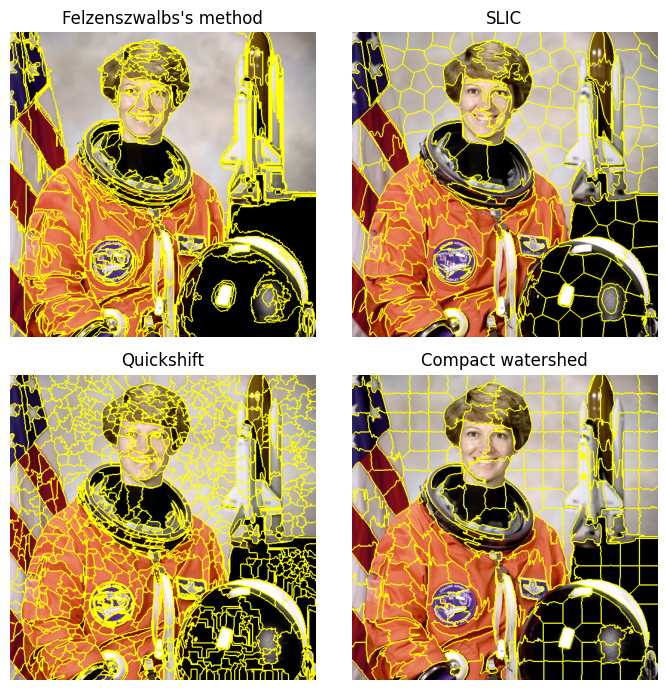

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

### Lime Image Explanation

In [25]:
segmenter = SegmentationAlgorithm(
    algo_type="slic",
    n_segments=100,
    compactness=1,
    sigma=1,
)

In [26]:
explainer = lime_image.LimeImageExplainer()

In [27]:
idx = 0

In [28]:
explanation = explainer.explain_instance(
    X_test[idx],
    classifier_fn=pipeline.predict_proba,
    top_labels=6,
    num_samples=1000,
    segmentation_fn=segmenter
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
probs = pipeline.predict_proba([X_test[idx]])[0]
probs

array([2.39611458e-04, 4.41679110e-13, 1.78096257e-03, 1.34534508e-04,
       9.11050439e-01, 2.48623663e-03, 9.65798215e-04, 7.47214628e-08,
       8.19073932e-04, 3.73861303e-06, 4.89667578e-14, 2.18445857e-04,
       9.59088735e-04, 1.00482529e-08, 2.92659115e-05, 8.17460023e-06,
       2.80133542e-03, 1.41971992e-04, 3.57891672e-08, 5.23105825e-07,
       3.52019705e-02, 7.41749182e-06, 1.06471554e-04, 2.86011250e-08,
       4.38215284e-05, 1.59777687e-06, 2.77928939e-12, 1.49002266e-09,
       1.62368906e-06, 1.75426012e-05, 6.56533567e-03, 8.10690182e-08,
       1.03214797e-05, 3.43622353e-11, 7.83296209e-03, 8.83053872e-05,
       7.63489050e-10, 4.91005543e-04, 2.61424982e-04, 2.77308151e-02],
      dtype=float32)

In [30]:
sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)[:6]

[4, 20, 39, 34, 30, 16]

In [31]:
# explainer uses classifier_fn to predict output labels
explanation.top_labels

[4, 20, 39, 34, 30, 16]

In [32]:
# temp = X_test[idx]
temp_pos, mask_pos = explanation.get_image_and_mask(
    y_test[idx],
    positive_only=True,
    num_features=8,
    hide_rest=False
)
temp_all, mask_all = explanation.get_image_and_mask(
    y_test[idx],
    positive_only=False,
    num_features=8,
    hide_rest=False
)

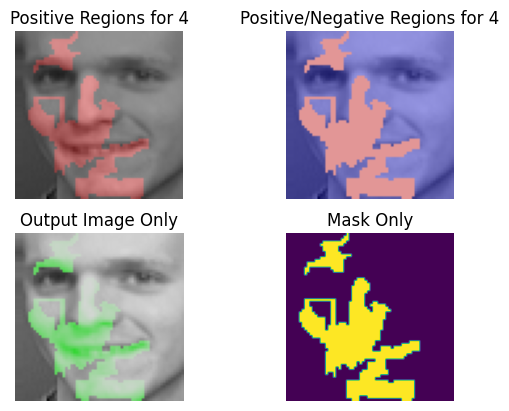

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(label2rgb(mask_pos, temp_pos, bg_label=0))
ax1.set_title(f"Positive Regions for {y_test[idx]}")

ax2.imshow(label2rgb(4-mask_all, temp_all, bg_label=0))
ax2.set_title(f"Positive/Negative Regions for {y_test[idx]}")

ax3.imshow(temp_all)
ax3.set_title("Output Image Only")

ax4.imshow(mask_all)
ax4.set_title("Mask Only")

for ax in [ax1, ax2, ax3, ax4]:
    ax.axis("off")

In [34]:
"""
Wrapper class for the example pipeline above (see src/surrogate/lime.py)
"""

lis = LimeImageSummarizer(
    explainer=explainer,
    segmentation_fn=segmenter,
    classifier_fn=pipeline.predict_proba
)

In [35]:
lis.set_data(X_test, y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

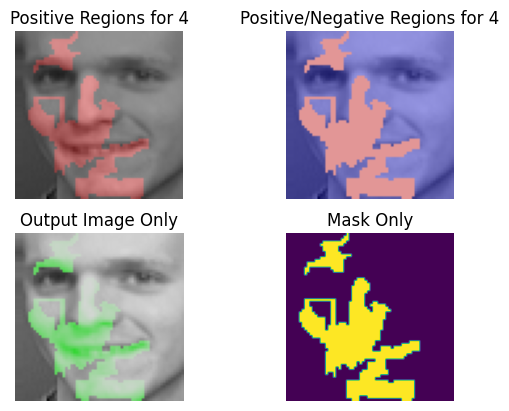

In [36]:
explanation, fig = lis(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

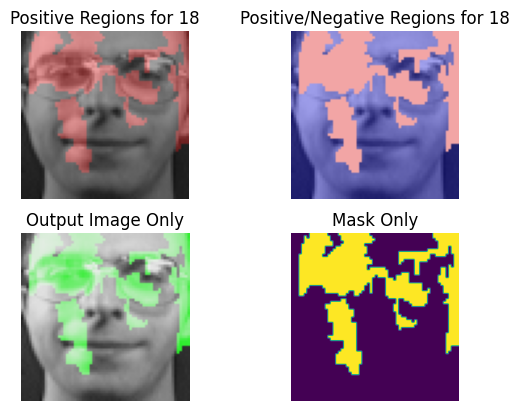

In [37]:
explanation, fig = lis(3)

  0%|          | 0/1000 [00:00<?, ?it/s]

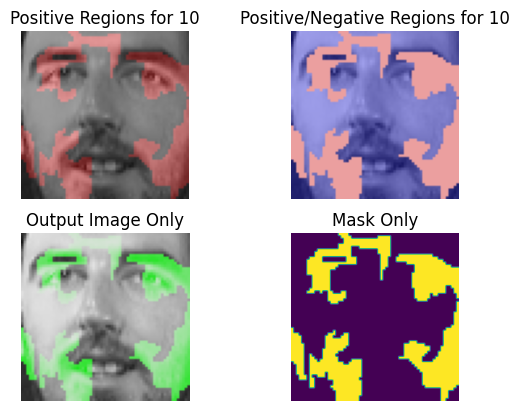

In [38]:
explanation, fig = lis(30)

### False Examples
- model shows low precision for label = 0, 17, 24

In [39]:
print(report_test)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      0.67      0.80         3
           7       1.00      0.80      0.89         5
           9       1.00      0.80      0.89         5
          10       0.75      0.75      0.75         4
          11       1.00      1.00      1.00         4
          12       0.40      1.00      0.57         2
          13       1.00      1.00      1.00         4
          14       0.80      1.00      0.89         4
          15       1.00      1.00      1.00         2
          16       0.83      0.83      0.83         6
          17       0.50      1.00      0.67         1
          18       1.00    

In [40]:
low_precision_label = [0, 12, 17, 24]

In [41]:
cases = []
for i, lb in enumerate(pred_test):
    if lb in low_precision_label and pred_test[i] != y_test[i]:
        cases.append(i)
        print(f"Index: {i} (True: {y_test[i]}, Pred: {pred_test[i]})")

Index: 2 (True: 7, Pred: 0)
Index: 66 (True: 22, Pred: 12)
Index: 67 (True: 22, Pred: 12)
Index: 88 (True: 3, Pred: 12)
Index: 91 (True: 9, Pred: 17)
Index: 94 (True: 22, Pred: 24)
Index: 102 (True: 22, Pred: 24)


In [42]:
bbox = fig.get_tightbbox(fig.canvas.get_renderer())

  0%|          | 0/1000 [00:00<?, ?it/s]

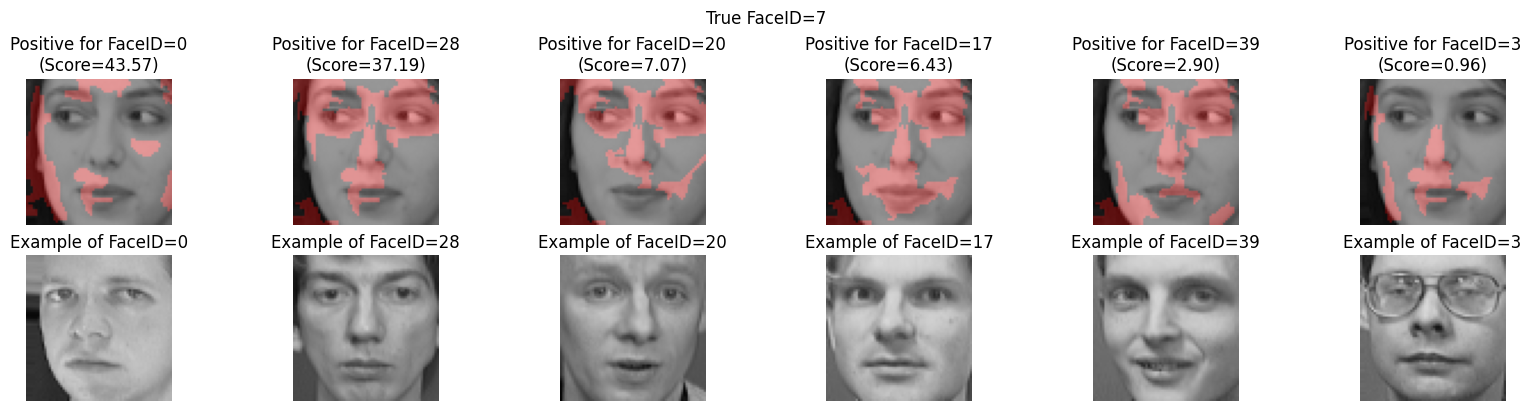

In [43]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

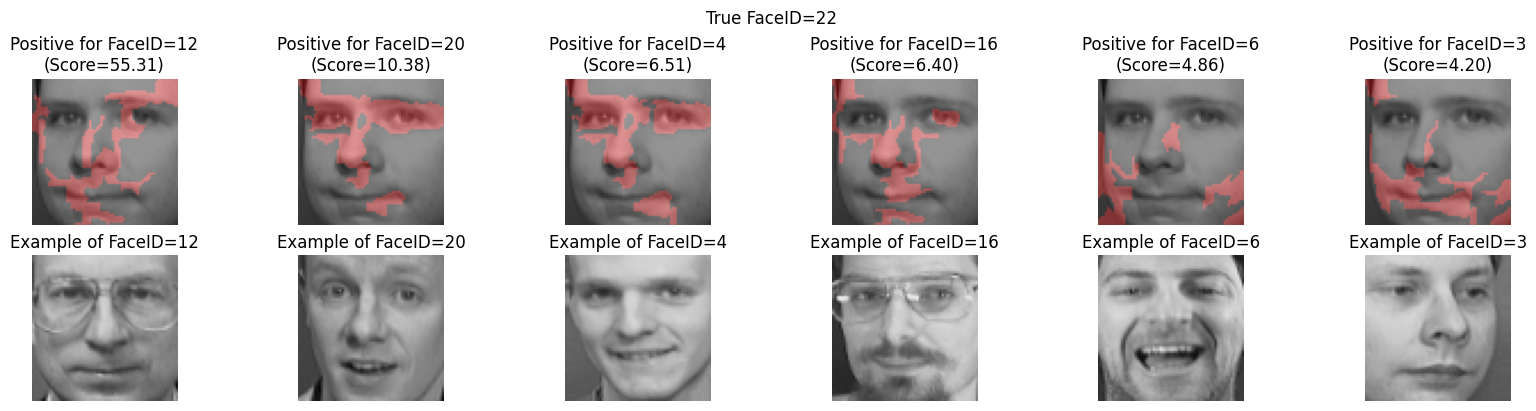

In [44]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[1])

  0%|          | 0/1000 [00:00<?, ?it/s]

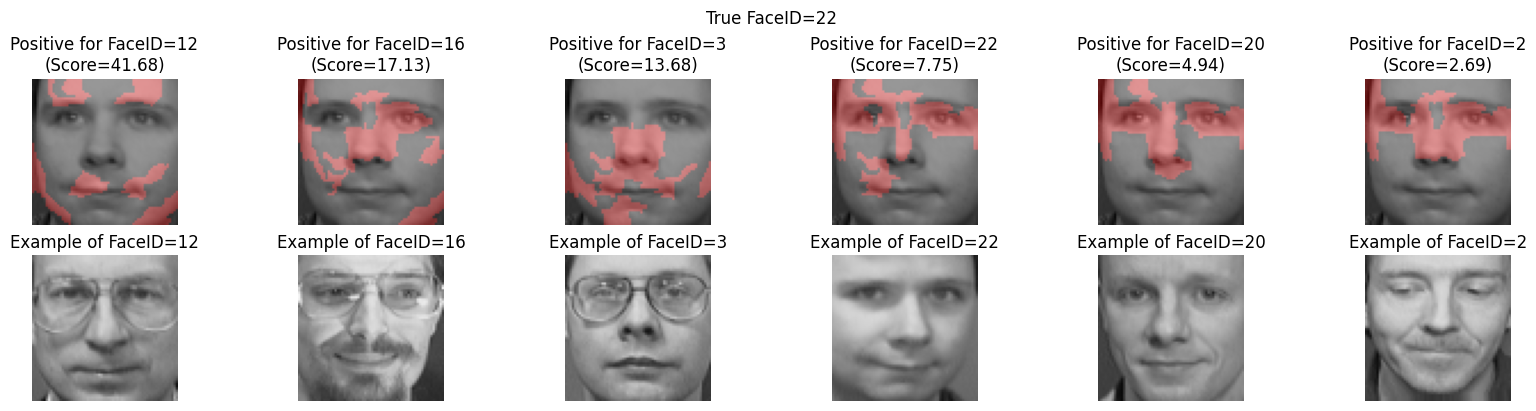

In [45]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[2])

  0%|          | 0/1000 [00:00<?, ?it/s]

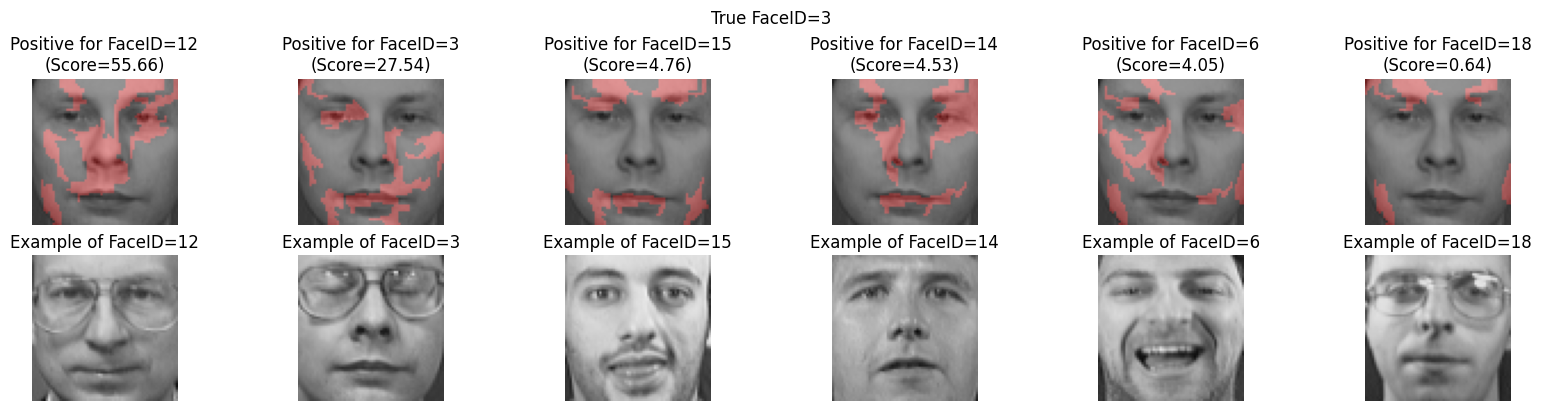

In [46]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[3])

  0%|          | 0/1000 [00:00<?, ?it/s]

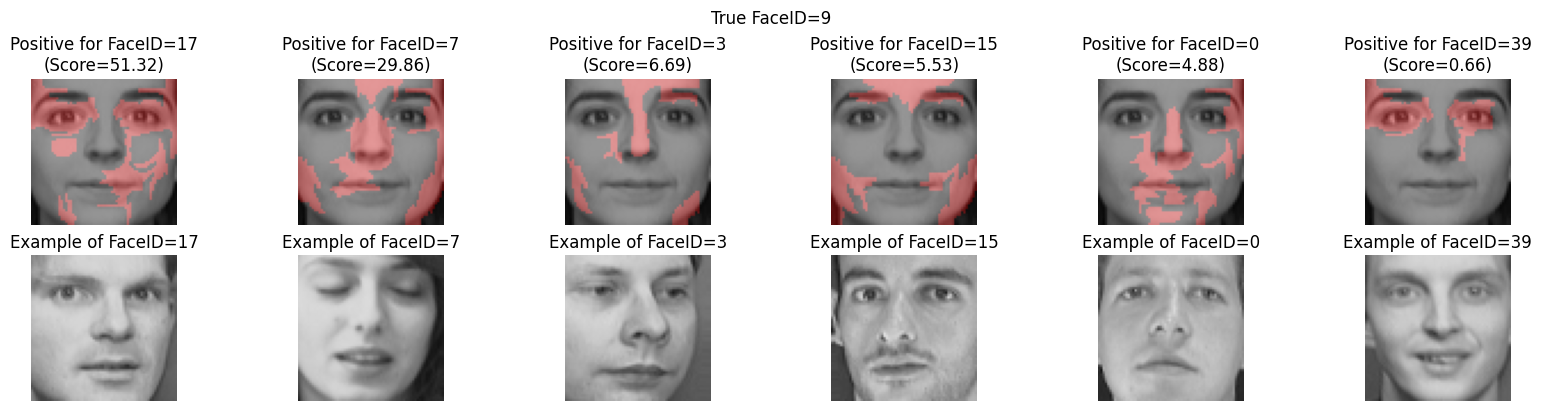

In [47]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[4])

  0%|          | 0/1000 [00:00<?, ?it/s]

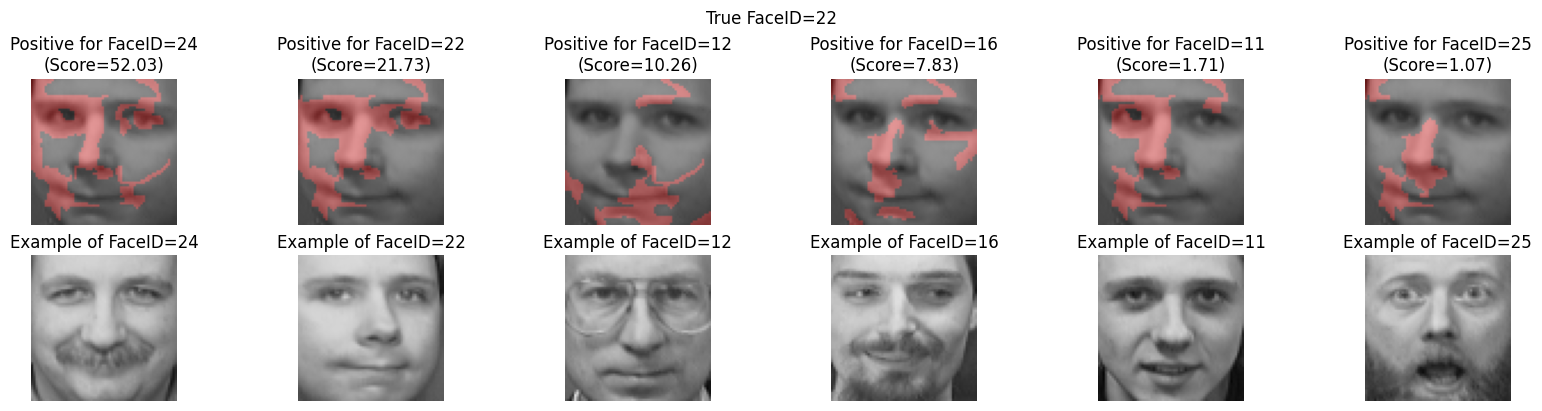

In [48]:
explanation, fig = lis.display_false_examples(X=X_train, y=y_train, idx=cases[5])